# SUSA CX Kaggle Capstone Project
## Part 4: Deep Learning in Keras and Submitting to Kaggle

### Table Of Contents
* [Introduction](#section1)
* [Initial Setup](#section2)
* [Deep Learning](#section3)
* [Final Kaggle Evaluation](#section4)   
* [Conclusion](#conclusion)
* [Additional Reading](#reading)


### Hosted by and maintained by the [Statistics Undergraduate Students Association (SUSA)](https://susa.berkeley.edu). Originally authored by [Patrick Chao](mailto:prc@berkeley.edu) & [Arun Ramamurthy](mailto:contact@arun.run).

<a id='section1'></a>
# SUSA CX Kaggle Capstone Project

Woohoo! You've made it to the end of the CX Kaggle Capstone Project! Congratulations on all of your hard work so far. We hope you've enjoyed this opportunity to learn new modeling techniques, some underlying mathematics, and even make new friends within CX. At this point, we've covered the entirety of the Data Science Workflow, linear regression, feature engineering, PCA, shrinkage, hyperparameter tuning, decision trees and even ensemble models. This week, we're going to finish off this whirlwind tour with a revisit to our old friend, Deep Learning. While the MNIST digit dataset was really interesting to look at as a cool toy example of the powers of DL, this time you're going to apply neural networks to your housing dataset for some hands-on practice using Keras. 

> ### CX Kaggle Competition & Final Kaggle Evaluation
After you get some practice with deep learning, this week we will be asking you and your team to select and finalize your best model, giving you the codespace to write up your finalized model and evaluate it by officially submitting your results to Kaggle. The winners of this friendly collab-etition will be honored at the SUSA Banquet next Friday, including prizes for the winning team! We also want to encourage and facilitate discussion between teams on why different models performed differently, and give you a chance to chat with other teams about their own experiences with the CX Kaggle Capstone. 

## Logistics

Most of the logistics are the same as last week, but we are repeating them here for your convenience. Please let us know if you or your teammates are feeling nervous about the pace of this project - remember that we are not grading you on your project, and we really try to make the notebooks relatively easy and fast to code through. If for any reason you are feeling overwhelmed or frustrated, please DM us or talk to us in person. We want all of you to have a productive, healthy, and fun time learning data science! If you have any suggestions or recommendations on how to improve, please do not hesitate to reach out!


### Mandatory Office Hours

Because this is such a large project, you and your team will surely have to work on it outside of meetings. In order to get you guys to seek help from this project, we are making it **mandatory** for you and your group to attend **two (2)** SUSA Office Hours over the next 4 weeks. This will allow questions to be answered outside of the regular meetings and will help promote collaboration with more experienced SUSA members.

The schedule of SUSA office hours are below:
https://susa.berkeley.edu/calendar#officehours-table

We understand that most of you will end up going to Arun or Patrick's office hours, but we highly encourage you to go to other people's office hours as well. There are many qualified SUSA mentors who can help and this could be an opportunity for you to meet them.

<a id='section2'></a>
# Initial Setup

To begin we will import all the necessary libraries and functions.

In [1]:
# Import statements
from sklearn import tree # There are lots of other models from this module you can try!
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge, Lasso, LinearRegression, Ridge
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.externals.six import StringIO  
from IPython.display import Image  


sqrt=np.sqrt

C:\Users\kshitiz\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\kshitiz\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We also define a few familiar functions that should be helpful to you later.

In [2]:
def get_features(data, col_list, y_name):
    """
    Function to return a numpy matrix of pandas dataframe features, given k column names and a single y column
    Outputs X, a n X k dimensional numpy matrix, and Y, an n X 1 dimensional numpy matrix.
    This is not a smart function - although it does drop rows with NA values. It might break. 
    
    data(DataFrame): e.g. train, clean
    col_list(list): list of columns to extract data from
    y_name(string): name of the column you to treat as the y column
    
    Ideally returns one np.array of shape (len(data), len(col_list)), and one of shape (len(data), len(col_list))
    """
    
    # keep track of numpy values
    feature_matrix = data[col_list + [y_name]].dropna().values
    np.random.shuffle(feature_matrix)
    return feature_matrix[:, :-1], feature_matrix[:, -1]

def get_loss(model, X,Y_true):
    """Returns square root of L2 loss (RMSE) from a model, X value input, and true y values
    
    model(Model object): model we use to predict values
    X: numpy matrix of x values
    Y_true: numpy matrix of true y values
    """
    Y_hat = model.predict(X)
    return get_RMSE(Y_hat,Y_true)

def get_RMSE(Y_hat,Y_true):
    """Returns square root of L2 loss (RMSE) between Y_hat and true values
    
    Y_true: numpy matrix of predicted y values
    Y_true: numpy matrix of true y values
    """
    return np.sqrt(np.mean((Y_true-Y_hat)**2))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def get_train_and_val(X,Y):
    """Given the X and Y data, return the training and validation based on the split variable
    
    X: numpy matrix of x values
    Y: numpy matrix of y values
    split: value between 0 and 1 for the training split
    """
    
    Y = Y.reshape(Y.shape[0],)

    train_index,_ = get_train_val_indices(X,Y)

    y_train = Y.reshape(Y.shape[0],)
    y_train = Y[:train_index]
    x_train = X[:train_index,:]

    x_val = X[train_index:,:]
    y_val = Y[train_index:]
    return (x_train,y_train),(x_val,y_val)

def get_train_val_indices(X,Y=None,split=0.7):
    train_index = (int)(X.shape[0]*split)
    test_index =X.shape[0]-1
    return train_index,test_index

def select_columns_except(dframe, non_examples):
    """Returns all comlumns in dframe except those in non_examples."""
    all_cols = dframe.select_dtypes(include=[np.number]).columns.tolist()
    cond = lambda x: sum([x == col for col in non_examples]) >= 1
    return [x for x in all_cols if not cond(x)]

#Metric for keras
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


## Data Loading

First, we need to load and clean the data. Although you may have cleaned data from `kaggle1`, we provide our solution for the cleaned housing data for your convenience. If you would like to view the completed data cleaning procedure, it has been updated in [kaggle1.ipynb](kaggle1.ipynb).

In [37]:
train = pd.read_csv('DATA/house-prices/train_cleaned.csv')
test = pd.read_csv('DATA/house-prices/test_cleaned.csv')
type(train)

pandas.core.frame.DataFrame

Same as before, we need to preprocess the data into `numpy` matrices and separate the `SalePrice` as the response variable.

We provide a function `model_prediction` that takes in a model and a set of features from the test set, and outputs the predictions into a vector. This should work with the `keras` neural networks, `sklearn` decision trees and random forests. 

## Model Example 1 : Random Forest
To help you get started, we supply a couple of naive models. Recall the three steps to modeling: model selection, training, and evaluation (validation or testing). Use the optimal parameters you found from grid search last week to tune the following random forest model.

In [4]:
####################
### MODEL DESIGN ###
####################
max_depth = 10 
min_samples_leaf = 1 
min_samples_split = 4
n_estimators = 40
model_rf = RandomForestRegressor(max_depth = max_depth,
                              min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split,
                              n_estimators = n_estimators, random_state = 0, bootstrap = True)

In [5]:
################
### TRAINING ###
################
model_rf = model_rf.fit(x_train, y_train)

NameError: name 'x_train' is not defined

In [ ]:
##################
### EVALUATION ###
##################
loss = get_loss(model_rf, x_val,y_val)
print("Root Mean Squared Error loss on the Validation Set for our model: {:.2f}".format(loss))

<a id='section3'></a>
# Deep Learning

From `kaggle3`, a strange tale:  
>We may imagine hyperparameters as a bunch of individual knobs we can turn to change our model. Consider that you are visiting your friend and staying at her place. However, you did not realize that she is actually an alien and her house is filled with very strange objects. When you head to bed, you attempt to use her shower, but see that her shower is has a dozen of knobs that control the temperature of the water coming out! We only have a single output to work off of, but many different knobs or *parameters* to adjust. If the water is too hot, we can turn random knobs until it becomes cold, and learn a bit about our environment. We may determine that some knobs are more or less sensitive, just like hyperparameters. Each knob in the shower is equivalent to a hyperparameter we can tune in a model.

## Model Example 2 : Neural Networks
Here is a very simple example of a neural network in Keras. It's performance is not fantastic to start, but mess around with tuning parameters and adding or subtracting layers and see what you can come up with!

In [ ]:
# ####################
# ### MODEL DESIGN ###
# ####################
# model_nn = Sequential()
# model_nn.add(Dense(30, activation='relu', input_shape=(x_train.shape[1],)))
# model_nn.add(Dense(1, activation='relu'))

# model_nn.compile(optimizer=Adam(), loss = root_mean_squared_error, 
#               metrics =[root_mean_squared_error])

In [ ]:
# ################
# ### TRAINING ###
# ################
# batch_size = 20
# epochs = 50
# learning_rate = 0.01
# history = model_nn.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_val, y_val))

In [ ]:
# ##################
# ### EVALUATION ###
# ##################
# score = model_nn.evaluate(x_val, y_val, verbose=0)
# print("Root Mean Squared Error loss on the Validation Set for our neural net model: {:.2f}".format(score[0]))

<a id='section4'></a>
# Final Kaggle Evaluation

Congrats on finishing the last of the models we planned on teaching you about during the CX Kaggle Capstone! 

You have now covered five distinct models and a several related techniques to add to your data science bag-of-tricks: 
- Linear Models
    - Multivariate Linear Regression
    - Polynomial Regression
    - Shrinkage / Biased Regression / Regularization (i.e. Ridge, LASSO)
- Decision Trees
    - Random Forests
- Deep Learning
    - Sequential Neural Networks
- Auxiliary Techniques 
    - The Data Science Workflow
    - Data Cleaning
    - Interpreting EDA Graphs
    - Feature Engineering
    - Principal Component Analysis
    - Hyperparameter Tuning (i.e. grid search)
    - Ensemble Learning (i.e. bagging, boosting) 
    
Wow, that's a lot! We are really proud of you all for exploring these techniques, which constitute some of Berkeley's toughest machine learning and statistics classes. As always, if you want to learn more about any of these topics, or are hungry to learn about even more techniques, feel free to reach out to any one of the SUSA Mentors.

With the help of the above listing and your own team's preferences, choose a model and a couple of techniques to implement for your final model. We will provide you with a preamble and some space to construct and train your model, as well as a helper function to turn your output into an official Kaggle submission file.  

A huge part of the modeling process is to mess around with different models, approaches, and hyperparameters! Don't be afraid to get your hands dirty and explore!

In [38]:
feature_cols = select_columns_except(train, ['Id','SalePrice'])

X, Y = get_features(train, feature_cols, 'SalePrice')
(x_train,y_train),(x_val,y_val) = get_train_and_val(X,Y)

x_test = test.loc[:, test.columns != 'Id'].values
test_ids = test['Id'].values
print(feature_cols)

['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'CentralAir', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Fireplaces', 'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageQual', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'LandSlope', 'LotArea', 'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'Utilities', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'MSZoning_none', 'Street_Grvl', 'Street_Pave', 'Alley_Grv

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# HyperParamter Tuning

def modelfit(alg, x_train, y_train, x_val, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label= y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train, eval_metric='rmse')
        
    #Predict training set:
    predictions = alg.predict(x_eval)
    
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_val, predictions))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
  
    

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': 1,
 'subsample': 0.8}

In [ ]:


import xgboost as xgb
from sklearn.datasets import dump_svmlight_file


my_imputer = Imputer()
x_train = my_imputer.fit_transform(x_train )
x_val = my_imputer.transform(x_val)

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1)



modelfit(xgb1, x_train, y_train, x_val)

# my_model = XGBRegressor(n_estimators = 100, learning_rate=0.08, subsample = 0.75, max_depth = 7, colsample_bytree = 1)

# my_model.fit(x_train, y_train, earl_stopping_rounds=5, 
#              eval_set=[(x_val, y_val)], verbose=False)



In [65]:
from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

from xgboost.sklearn import XGBRegressor  
import scipy.stats as st
from sklearn.metrics import accuracy_score

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)  


from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(x_train, y_train)  
gs.best_params_ 

my_model = XGBRegressor()
my_model.fit(x_train, y_train, early_stopping_rounds=5, 
             eval_set=[(x_val, y_val)], verbose=False)

# make predictions for test data
y_pred = my_model.predict(x_val)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 0.00%


In [29]:
predictions = my_model.predict(x_val)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_val)))

from sklearn.metrics import mean_squared_error
print("Mean Squared Error : " + str(mean_squared_error(predictions, y_val)))
print("RMSE : ", mean_squared_error(predictions, y_val) ** 0.5)
print()


loss = get_loss(my_model, x_val,y_val)
print("Root Mean Squared Error loss on the Validation Set for our model: {:.2f}".format(loss))

Mean Absolute Error : 18973.3989892
Mean Squared Error : 1090727484.88
RMSE :  33026.1636416

Root Mean Squared Error loss on the Validation Set for our model: 33026.16


In [9]:
# Lasso Regression

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# train_lasso = pd.read_csv('DATA/house-prices/train_cleaned.csv')
# test_lasso = pd.read_csv('DATA/house-prices/test_cleaned.csv')
# %config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
# %matplotlib inline

full = pd.concat([train, test]).copy()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])


#log transform skewed numeric features:
numeric_feats = full.dtypes[full.dtypes != "object"].index


skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

full[skewed_feats] = np.log1p(full[skewed_feats])


x_train_lasso = full[:train.shape[0]]
x_val_lasso = full[train.shape[0]:]
y_train_lasso = train.SalePrice





0.05     0.081505
0.10     0.080958
0.30     0.079920
1.00     0.078904
3.00     0.078944
5.00     0.079372
10.00    0.080303
15.00    0.081036
30.00    0.082637
50.00    0.084070
75.00    0.085317
dtype: float64


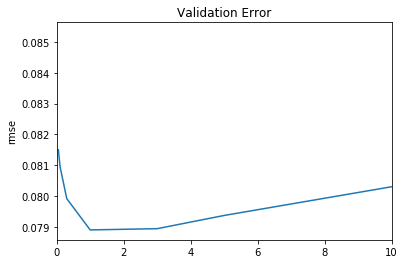

In [28]:
# Ridge Regression

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train_lasso, y_train_lasso, scoring="neg_mean_squared_error", cv = 5))
    
    return(rmse)



alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha, max_iter = 1000)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation Error")
plt.ylabel("rmse")
plt.xlim(0,10)

print(cv_ridge)

In [20]:
print(cv_ridge.min())

model_ridge = Ridge(alpha = 3)

0.0789035215931


Lasso picked 120 variables and eliminated the other 87 variables


Text(0.5,1,'Coefficients in the Lasso Model')

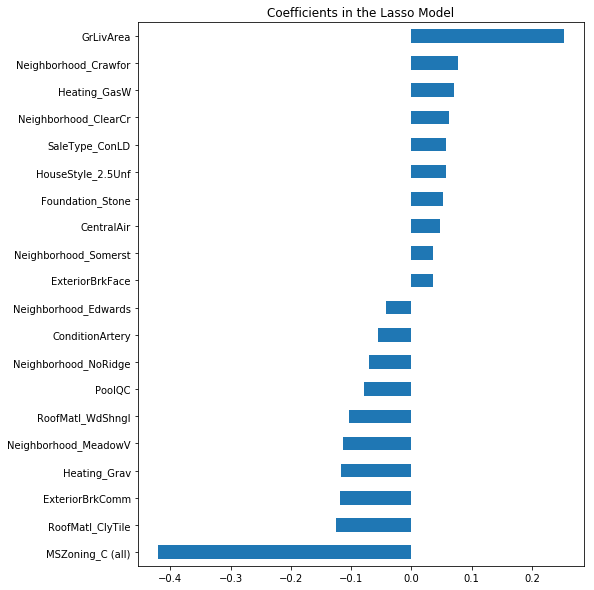

In [33]:
# Lasso

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0001, 0.00005], max_iter = 4000, tol = 0.0001).fit(x_train_lasso, y_train_lasso)
rmse_cv(model_lasso).mean()

# cv_lasso_df = pd.Series(cv_lasso, index = alphas)
# cv_lasso_df.plot(title = "Validation Error")
# plt.ylabel("rmse")

# Adding lasso and XgBoost

# xgb_preds = np.expm1(model_xgb.predict(X_test))
# ridge_preds = np.expm1(model_ridge.predict(x_val))



# preds = 0.7*lasso_preds + 0.3*xgb_preds

# solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
# solution.to_csv("ridge_sol.csv", index = False)

coef = pd.Series(model_lasso.coef_, index = x_train_lasso.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [30]:
def model_prediction(model,x_test=x_test):
    prediction = model.predict(x_test)
    return prediction.reshape(prediction.shape[0],)

In [31]:
###############
## PREAMBLE ###
###############
train = x_train
labels = y_train
test = x_test 

####################
### MODEL DESIGN ###
####################
model = my_model
# ^^ REPLACE THIS LINE ^^

################
### TRAINING ###
################
model = model.fit(train, labels)
# ^^ REPLACE THIS LINE ^^

##################
### EVALUATION ###
##################
# model = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 0.0005], max_iter = 10000, tol = 0.001).fit(x_train, y_train)
test_predictions = model_prediction(model)




##################
### SUBMISSION ###
##################
def generate_kaggle_submission(predictions, test = test):
    '''
    This function accepts your 1459-dimensional vector of predicted SalesPrices for the test dataset, 
    and writes a CSV named kaggle_submission.csv containing your vector in a form suitable for 
    submission onto the Kaggle leaderboard.
    '''
    pd.DataFrame({'Id': test_ids, 'SalePrice': predictions}) \
      .to_csv('kaggle_submission.csv', index=False)
    
generate_kaggle_submission(test_predictions)

As you might have noticed in the code block above, we had to write a simple CSV file containing row IDs and predicted values for the 1459 houses in the test dataset. This submission file is your ticket to getting onto the official Kaggle leaderboard and seeing how you did as compared to the rest of the world! 

Take a look at your `kaggle_submission.csv` file to ensure its content matches your expectations. When you and your team are ready, follow these instructions to upload your predictions to Kaggle and receive an official Kaggle score:

> 1. First, choose one person on your team (perhaps the rprincess) to submit your team's predictions under their name. This person will need to visit the [Kaggle website](https://www.kaggle.com) to create an account.
> 2. Go to the [Competition Submission Page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit) for the House Prices competition. 
> 3. Upload and submit `kaggle_submission.csv`
> 4. Wait for your submission to be scored! This should only take a few seconds to submit. You may have to refresh the page to see your final score.
> 5. To each member: record your team's score in [this Google form](https://goo.gl/forms/VteqJ5Di84t54TEZ2), which also contains a section for feedback on your Kaggle experience this semester. Congratulations on your first Kaggle submission!

For initial comparison, the naive random forest in this notebook achieves a score of 0.15-0.2 - you can think of this as a baseline score to beat.   

This is Patrick's score after some minor edits to the models above:

<img src="GRAPHICS/kaggle.png" width="80%">

Can you beat Patrick's Kaggle score?
> "As an incentive, if you get a score under 0.13, I will personally take your team out to lunch!" - Patrick Chao

If you get some great models and great kaggle scores, feel free to screenshot them and post them in the slack!

We will post a leaderboard of all of the CX Kaggle teams, and the winning team will be honored at banquet, so stay tuned for that! 

In the meantime, take some time to talk to other finished teams and explore the differences in your modeling approach, design, and insights! Happy Kaggling :) 

# Conclusion

This brings us to an end to the CX Kaggle Capstone Project, as well as the Spring 2018 semester of SUSA Career Exploration. Congratulations on graduating from the SUSA Career Exploration committee! It's been a wonderful experience teaching you all, and we hope you got as much out of CX as we did this semester. This semester brought several new pilot programs to CX, such as the crash courses, workbooks, a revamped curriculum, and the CX Kaggle Capstone Project. You all have been great sources of feedback, and we want to make next semester's CX curriculum even better for the new generation of CX! 

We're going to ask you for feedback one last time, to give us insight into how we can improve the CX Kaggle Capstone experience for future CX members. Please fill out [this feedback form](https://goo.gl/forms/VteqJ5Di84t54TEZ2) and let us know how we could have done better. Thank you again for a wonderful semester, and we will see you again in the Fall!

As always, please email [Arun Ramamurthy](mailto:contact@arun.run), [Patrick Chao](mailto:prc@berkeley.edu), or [Noah Gundotra](mailto:noah.gundotra@berkeley.edu) with any questions or concerns whatsoever. Have a great summer, and we hope to see you as a returning member in the Fall! Go SUSA!!!

**Signed with geom_love,  
Lucas, Arun, Patrick, Noah, and the rest of the SUSA Board**